- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
- Javier Alejandro Mejía Alecio #20304
- Erick Raúl Alvarez Melgar #20900

# Proyecto - Presentación de Resultados

Guatemala es conocido como el país de la eterna primavera, debido a su diversidad de flora y fauna, además de contar
con un clima conocido como templado, es decir no existen climas extremos a lo largo del año. Sin embargo, así como
es conocido por su belleza natural, también es fuertemente reconocible por la corrupción y los bajos índices de calidad
de vida, y uno de ellos es el de mortalidad, la cual expresa la frecuencia con la cual ocurren las defunciones en una
población dada, en el caso de Guatemala, para el año 2019 fue de 4.72% (Datosmacro, 2021), es decir en promedio 5 muertes por cada 1000 habitantes.
A continuación se realizará un análisis exploratorio, sobre los datos de defunciones reportados por el Instituto Nacional de
Estadística de Guatemala -INE- de los años 2011 a 2020, y dentro de los cuales se pretende encontrar una situación problemática
la cual a su vez pueda ser resuelta con los datos analizados.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree
import sklearn.metrics as skm
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVR
from sklearn.metrics import silhouette_score, mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn import tree

# Estilos
plt.style.use('ggplot')
#sns.set_theme(palette=None)

In [13]:
# Cargar los datos
deaths = pd.read_csv('final.csv')
# Como ya se cuenta con la causa de muerte (categorizada) la descripción sale sobrando
# De igual forma, el periodo de edad se puede obtener mediante la edad así que es info redundante
deaths = deaths.loc[:, deaths.columns != 'Perdif']
deaths = deaths.loc[:, deaths.columns != 'caudef.descrip']

C:\Users\ALVAREZ\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (7,12,18,22,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Se procedió a realizar una simplificación a causas comunes en la variable Caudef, la cual indica la causa de defunción. Esto debido a que dicha variable presentaba resultados variados, los cuales no aportan a los modelos.


In [8]:
deaths['cause'] = deaths['Caudef'].copy()
repl = {r'([AB])(\d+.*)' : r'AB',
        r'(C)(\d+.*)' : r'CD',
        r'(D[0-4])(\d+.*)' : r'CD',
        r'(D[5-8])(\d+.*)' : r'DD',
        r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF',
        r'(G)(\d+.*)' : r'GG',
        r'(H[0-5])(\d+.*)' : r'HA',
        r'(H[6-9])(\d+.*)' : r'HB',
        r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ',
        r'(K)(\d+.*)' : r'KK',
        r'(L)(\d+.*)' : r'LL',
        r'(M)(\d+.*)' : r'MM',
        r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO',
        r'(P)(\d+.*)' : r'PP',
        r'(Q)(\d+.*)' : r'QQ',
        r'(R)(\d+.*)' : r'RR',
        r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY',
        r'([Z])(\d+.*)' : r'ZZ',
        r'([U])(\d+.*)' : r'UU',
        }
deaths.cause = deaths['cause'].replace(repl, regex=True)
deaths['cause']

0         II
1         UU
2         RR
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

Dado que no se pretende trabajar con información de difuntos, se procedió a eliminar toda la información pertinente a los difuntos.


In [10]:
# Eliminación de toda la información pertinente al difunto en sí, porque no se pretende trabajar con los difuntos en sí
sample = deaths.drop(['Areag', 'Depreg', 'Mupreg', 'Mesreg', 'Añoreg','Depocu','Edadif','Puedif','Ecidif','Escodif','Ciuodif','Pnadif','Dnadif','Mnadif', 'Nacdif', 'Predif', 'Dredif', 'Mredif', 'Sexo', 'Caudef'], axis=1)

## Creación de la variable de predicción: Número de muertes


In [11]:
# Creación de la nueva variable de predicción
# Variable de predicción: número de muertes por municipio_ocurrencia/mes_ocurrencia y causa
sample = sample.groupby(by=['cause','Mupocu', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur', 'Cerdef']).count()
sample.columns = ['number_deaths']

In [12]:
# Nuevo conjunto de datos
sample = sample.reset_index(level=['cause', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur','Cerdef','Mupocu'])

Cruce las variables que considere que son las más importantes para hallar los elementos clave que lo pueden llevar a
comprender lo que está causando el problema encontrado.

Para hacer el cruce de las variables y comprender si existe cierta asociación entre dichas variables se utilizará Cramer´s V
la cual es una medida de la longitud entre variables categóricas, básicamente mide la relación entre las variables. Su valor
varía de 0 a 1, donde 0 indica que no existe ningún tipo de asociación entre las variables y 1 que sí existe asociación entre
las mismas. Por otro lado, también se utilizarán las tablas de contingencia para hacer el "cruce" de las variables.

Durante el análisis exploratorio de los datos y mediante las diversas preguntas que se plantearon para conocer dichos datos
se pudo encontrar que existe una gran parte de las defunciones las cuales NO reciben asistencia médica, y esto es más notorio
cuando se habla de asistencia médica por pueblo de pertenencia. Por lo tal, se evaluará únicamente la asociación de las variables
con respecto al tipo de asistencia que reciben.

In [14]:
# Evaluar la correlación de las variables para ver cuáles se pueden eliminar
for column in sample.columns:
  if column != 'cause':
    crosstable = pd.crosstab(sample[column], sample['cause'])
    print(crosstable)
    print('Asociación: ', contingency.association(crosstable))

cause         AB   CD  DD   EE  FF  GG  HA  HB   II   JJ   KK  LL  MM  NN  OO  \
Mupocu                                                                          
Acatenango    26  139   6   60   4  18   0   0  189  149   89   1   3  18   0   
Agua Blanca   10  112   3   84   1   3   0   0  314   93   36   0   1  15   0   
Aguacatán    190  284  11  146  13  37   0   0  343  328  144   2  11  84  10   
Almolonga     15  102   7  220  13  13   0   0  183  101  109   0  10  46   0   
Alotenango    31   72  11  130  10  19   0   0  201  156   56   3   2  24   0   
...          ...  ...  ..  ...  ..  ..  ..  ..  ...  ...  ...  ..  ..  ..  ..   
Zacualpa     174  118  15  101  20  20   0   1  134  214   89   3   2  36   3   
Zapotitlán     8   64   1   34   1   4   0   0  139   16   10   0   0  15   0   
Zaragoza      12  125   1   80  19  10   0   0  144  117   96   3   7  27   0   
Zunil         15   66   6  126   8  15   0   0  136   56   65   0   0  30   2   
Zunilito       7   32   0   

cause          AB     CD    DD     EE    FF    GG  HA  HB     II     JJ  \
Asist                                                                     
Comadrona      41     28     7     24     2     3   0   0     22     47   
Empírica     2017   1569   405   2219   117   323   2   0   3035   3300   
Ignorado      164    446    18    493    31    80   0   0   1004    572   
Médica      14099  32872  4254  38098  2375  7861   7  17  47389  27735   
Ninguna     21202  36186  2095  31255  3127  6784  13  18  60080  50784   
Paramédica    157    202    22    261    23    36   0   0    403    315   

cause          KK   LL    MM     NN    OO     PP    QQ     RR    UU     VY  
Asist                                                                       
Comadrona      23    1     2     11   152    184    23     43     0     17  
Empírica     1696   35    64    726    92    318   174   1069    16    618  
Ignorado      533    9     8    175    16     44    30    768    18   4653  
Médica      26

Se procedió a eliminar aquellas variables que presentaban una alta correlación, esto con motivos para evitar el overfit en nuestros modelos de regresión.


In [8]:
sample = sample.drop(['Asist', 'Diaocu', 'Cerdef'], axis=1)

In [15]:
sample = sample.groupby(['cause', 'Mesocu', 'Añoocu', 'Ocur','Mupocu']).count()
sample = sample.reset_index(level=['cause', 'Mesocu', 'Añoocu', 'Ocur','Mupocu'])

Finalmente se obtuvo una muestra del 50% de la base de datos, agrupado por la causa de defunción.


In [10]:
deaths_sample = sample.groupby('cause', group_keys=False).apply(lambda x: x.sample(frac=0.50, random_state=191943))


In [11]:
deaths_sample

,cause,Mesocu,Añoocu,Ocur,Mupocu,number_deaths
7186,AB,Julio,2011,Hospital público,Tiquisate,2
5230,AB,Enero,2017,Domicilio,San Miguel Acatán,1
14275,AB,Noviembre,2020,Domicilio,San Jorge,1
7797,AB,Julio,2015,Hospital público,Escuintla,6
7640,AB,Julio,2014,Hospital público,Antigua Guatemala,2
...,...,...,...,...,...,...
277422,VY,Mayo,2020,Ignorado,San Miguel Ixtahuacán,1
276888,VY,Mayo,2018,Vía pública,Villa Nueva,2
273705,VY,Marzo,2020,Otro,Ixcán,1
257933,VY,Enero,2018,Vía pública,Joyabaj,1


# Modelo: Árbol de Regresión

In [12]:
# Codificación de las variables
encoder = OrdinalEncoder(dtype=int)
for column in sample.columns:
        if column != 'Añoocu' and column != 'number_deaths':
                sample[column] = encoder.fit_transform(sample[[column]])
                print(encoder.categories_)

[array(['AB', 'CD', 'DD', 'EE', 'FF', 'GG', 'HA', 'HB', 'II', 'JJ', 'KK',
       'LL', 'MM', 'NN', 'OO', 'PP', 'QQ', 'RR', 'UU', 'VY'], dtype=object)]
[array(['Abril', 'Agosto', 'Diciembre', 'Enero', 'Febrero', 'Julio',
       'Junio', 'Marzo', 'Mayo', 'Noviembre', 'Octubre', 'Septiembre'],
      dtype=object)]
[array(['Centro de salud', 'Domicilio', 'Hospital privado',
       'Hospital público', 'Ignorado', 'Lugar de trabajo', 'Otro',
       'Seguro social', 'Vía pública'], dtype=object)]
[array(['Acatenango', 'Agua Blanca', 'Aguacatán', 'Almolonga',
       'Alotenango', 'Amatitlán', 'Antigua Guatemala', 'Asunción Mita',
       'Atescatempa', 'Ayutla', 'Barberena', 'Barillas', 'Cabañas',
       'Cabricán', 'Cahabón', 'Cajolá', 'Camotán', 'Canillá', 'Cantel',
       'Casillas', 'Catarina', 'Chahal', 'Chajul', 'Champerico',
       'Chiantla', 'Chicacao', 'Chicamán', 'Chichicastenango', 'Chiché',
       'Chimaltenango', 'Chinautla', 'Chinique', 'Chiquimula',
       'Chiquimulilla', 'Chis

In [13]:
# Variables para predecir
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']

Para poder crear el árbol se separó la base de datos en 2 partes, la parte de
entrenamiento, la cual sería el 70% de los datos y la parte de prueba, la cual sería el 30%
restante de los mismos. Con esto el 70% de los datos se utilizó para entrenar al blackbox.

Se decidió dividir en 0.3 y 0.7, esto para que el algoritmo tuviera la mayor cantidad de datos
para ser entrenado y obtener mejores resultados al momento de utilizar el 0.3 del archivo
para realizar el test.

In [14]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.3, stratify=predictors['cause'])


In [15]:
regression_model = DecisionTreeRegressor(max_depth=15, random_state=42)
regression_model = regression_model.fit(X=predictors_train, y=target_train)

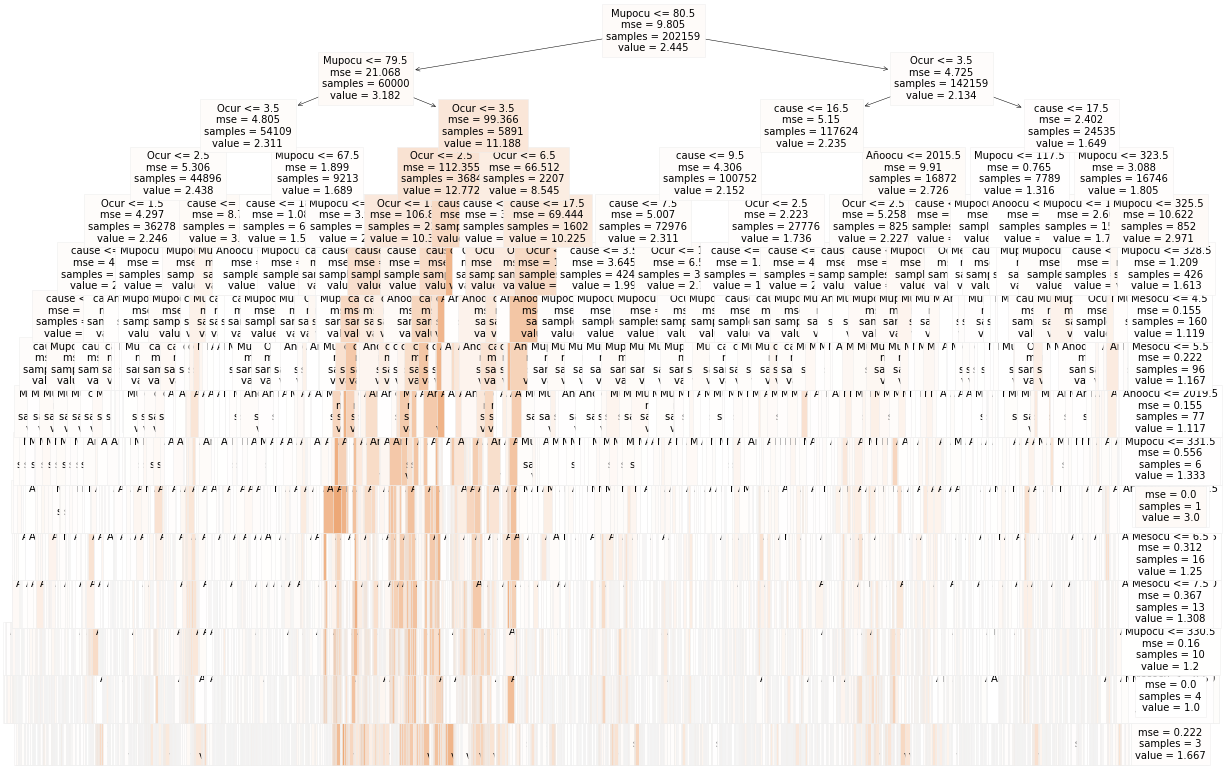

In [16]:
plt.figure(figsize=(20, 14))
plot_tree(decision_tree=regression_model,feature_names=predictors.columns, filled=True, fontsize=10);

### Análisis de los resultados del Modelo Árbol de Regresión

### Evaluando la prediccón del Modelo

In [17]:
# Evaluando la predicción
prediction = regression_model.predict(predictors_test)
results = pd.DataFrame({
    'Predicted': prediction,
    'Real': target_test
})

results

,Predicted,Real
253909,3.666667,9
204705,1.042017,1
232475,12.414634,13
120831,3.883721,8
155505,1.327273,1
...,...,...
98143,1.724638,1
46673,2.000000,2
34548,1.689038,4
136584,2.818182,1


In [80]:
print ("Variance Score:",skm.explained_variance_score(target_test, prediction, multioutput='raw_values'))
print("R squared: %.2f"%r2_score(target_test,prediction))
print ("Max Error:", skm.mean_absolute_error(target_test, prediction))

Variance Score: [-0.80692177]
R squared: -0.81
Max Error: 2.091474813000841


### Análisis de las métricas del Modelo Árbol de Regresión

# Modelo: Random Forest Regresión

El modelo de regresión de Random Forest está formado por un conjunto de árboles de decisión individuales, cada uno entrenado con una muestra aleatoria, extraída de los datos de entrenamiento originales. Esto significa que cada árbol se entrena de manera individual con datos ligeramente distintos, por lo que las observaciones se van distribuyendo por bifurcaciones, generando la estructura del árbol hasta alcanzar un nodo terminal. Con esto podemos garantizar la predicción de una nueva observación, la cual se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo. Esta fue una de las principales razones por las que se decidió utilizar este modelo, el cual fue de los más efectivos al momento de aplicar todos los modelos aprendidos durante el curso a los distintos conjuntos de datos.


#### Multicolinealidad de las variables

In [51]:
vif_data = pd.DataFrame() 
G = sample
vif_data["feature"] = G.columns
  
vif_data["VIF"] = [variance_inflation_factor(G.values, i) 
                          for i in range(len(G.columns))] 
  
print(vif_data)

         feature       VIF
0          cause  3.824573
1         Mesocu  3.528934
2         Añoocu  9.532144
3           Ocur  2.613361
4         Mupocu  3.483222
5  number_deaths  1.625157


De acuerdo con el análisis de múlticolinealidad se debe hacer un drop del año de ocurrencia

In [63]:
encoder = OrdinalEncoder(dtype=int)
for column in G.columns:
        if column != 'number_deaths':
                G[column] = encoder.fit_transform(G[[column]])
                print(encoder.categories_)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])]
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])]
[array([0, 1, 2, 3, 4, 5, 6, 7, 8])]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144

In [64]:
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']
predictors = predictors.drop(['Añoocu'], axis = 1)

Para poder crear el Random Forest se separó la base de datos en 2 partes, la parte de
entrenamiento, la cual sería el 70% de los datos y la parte de prueba, la cual sería el 30%
restante de los mismos. Con esto el 70% de los datos se utilizó para entrenar al blackbox.

Se decidió dividir en 0.3 y 0.7, esto para que el algoritmo tuviera la mayor cantidad de datos
para ser entrenado y obtener mejores resultados al momento de utilizar el 0.3 del archivo
para realizar el test.

In [65]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.3, stratify=predictors['cause'])
print(predictors_train)

        cause  Mesocu  Ocur  Mupocu
79562       4       2     1     312
193051     13       4     1     241
117344      8       8     1     249
239536     17      10     4     118
175400     10       8     4     214
...       ...     ...   ...     ...
31665       1       6     7      68
39784       1       9     1     255
92993       8       0     1     175
91300       5      10     1     172
149833      9       8     1     160

[202159 rows x 4 columns]


In [90]:
CT = RandomForestRegressor(n_estimators=50, max_depth=15, random_state = 1000)
CT.fit(predictors_train,target_train)

RandomForestRegressor(max_depth=15, n_estimators=50, random_state=1000)

In [94]:
Y_pred = CT.predict(predictors_test)
YT_pred = CT.predict(predictors_train)
#Y_Pred_Tero = SR.predict()

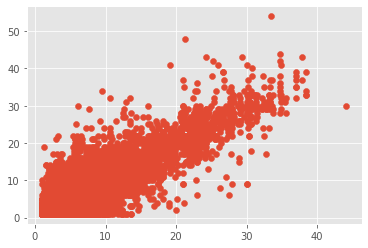

In [95]:
plt.scatter(Y_pred, target_test)

Se observó que al graficar los valores predecidos vs los reales, estos tienen una tendencia lineal, lo que significó que en efecto la mayor parte de los datos predichos por el modelo entrenado fueron exactos. 


In [96]:
print("R squared: %.2f"%r2_score(target_test,Y_pred))
print("R squared teórico: %.2f"%r2_score(target_train,YT_pred))

R squared: 0.74
R squared teórico: 0.77


Al aplicar el random forest para obtener la regresión de los valores y predecir las muertes, se utilizó la función.fit. Se observó que los valores fueron predichos con éxito, esto debido a que se obtuvo un R² de 0.74 y un R² a los valores teóricos de 0.77. Dichos valores entre más cercanos a 1, significa que mejor es la predicción realizada. Además, al observar que existe una similitud entre el R² del entrenamiento y del test, se confirmó que no hubo overfitting alguno. Por lo que se obtuvieron los resultados esperados.


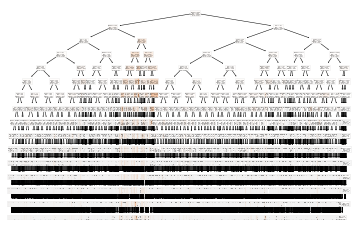

In [101]:
plt.figure()
_ = tree.plot_tree(CT.estimators_[0], feature_names=G.columns, filled=True)

#### Residuos

In [106]:
residuales = Y_pred - target_test

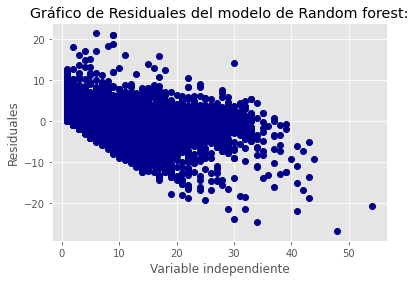

In [112]:
plt.plot(target_test,residuales, 'o', color='darkblue')
plt.title("Gráfico de Residuales del modelo de Random forest:")
plt.xlabel("Variable independiente")
plt.ylabel("Residuales")
plt.show()
# %%


En la gráfica de residuales se puede observar que los puntos se comportan de una manera aleatoria, lo cual nos da a saber que los datos utilizados siguen la distribución normal, lo que descarta errores sistematicos en la aplicación del modelo.

Por otro lado, los datos se distribuyen alrededor del 0, lo que significa que en efecto el modelo aplicado es válido, al igual que la distribución aleatoria en los residuos obtenidos


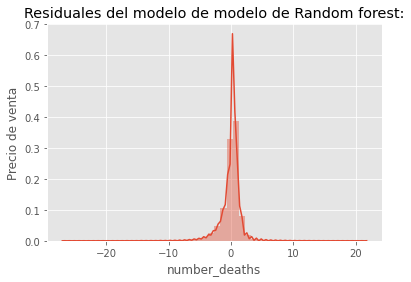

In [113]:
sns.distplot(residuales);
plt.title("Residuales del modelo de modelo de Random forest:")
plt.ylabel("Precio de venta")
plt.show()

En el histograma de residuales se puede observar que la mayoría de las barras se encuentra agrupada de una forma simétrica alrededor del 0. Además, por la prueba de normalidad se puede concluir que los datos de residuo tienen una distribución normal, por lo tanto, no hay un error sistemático en el modelo elaborado. De la misma forma podemos observar que existen unas barras alejadas del histograma, lo cual indica que existen datos atípicos, pero estas barras tienen una altura pequeña, lo cual no impactó la forma de nuestro histograma.

Además, al observar el gráfico de dispersión, se observan datos atípicos, esto en efecto confirma que no hay overfitting en nuestro modelo. Debido a que el algoritmo de entrenamiento predijo resultados distantes a los datos reales, es decir brindó falsos positivos y falsos negativos, lo cual se espera en un algoritmo entrenado como estos.


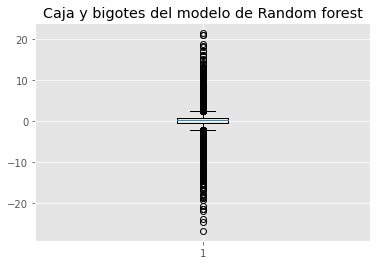

In [114]:
plt.boxplot(residuales)
plt.title('Caja y bigotes del modelo de Random forest')
plt.show()

De acuerdo al gráfico de caja y bigotes podemos determinar que la media de los residuos se encuentra cercana al 0, lo que nos indica que hubo un pequeño error entre el valor teórico y el predicho por la regresión. Por otro lado, se pueden observar datos atípicos en la gráfica pero tomando en cuenta la cantidad de datos de nuestra muestra, estos son insignificantes, tal como lo pudimos observar en el histograma realizado anteriormente.

## Conclusiones